# Bulldozer dataset

This notebook will use a datasets with a large number of columns (>30) and will propose and entire pipeline of treatments.

Will focus on here on the datasets distribution and sampling then we'll focus on features selection.

Of course, our first concern will the efficiency of our data, model score will be secondary we'll only get concern about it while working around feature selection.

In [1]:
import os
import json
import random
from pathlib import Path
from zipfile import ZipFile

In [2]:
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
df = pd.read_feather('tmp/feather')

In [5]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,11.09741,10.950807,9.21034,10.558414,9.305651
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,1.0,1.0,0.0,0.0,2.0
fiModelDesc,949.0,1724.0,330.0,3673.0,4207.0


Let's define some basic metrics to evaluate properly our model efficiency

In [6]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## Building a simple first sample of our dataset

Will our distribution will be the same ?

(array([ 1068.,   343.,  1305.,  1331.,  1782.,  2185.,  3392.,  5909.,
         8499.,  8065., 13491.,  6102.,  7790., 11979., 12695., 12996.,
        12561., 11805., 11742., 12112., 14414., 16148., 11874., 15097.,
        11456., 17200., 13035., 12418., 15152., 10927., 13740.,  8391.,
         8680., 10483.,  8982.,  5957.,  8675.,  7789.,  6538.,  6610.,
         6298.,  4974.,  5267.,  3772.,  4046.,  2437.,  1489.,  1030.,
          778.,   316.]),
 array([ 8.4658999 ,  8.53385355,  8.60180719,  8.66976084,  8.73771449,
         8.80566814,  8.87362179,  8.94157544,  9.00952909,  9.07748274,
         9.14543638,  9.21339003,  9.28134368,  9.34929733,  9.41725098,
         9.48520463,  9.55315828,  9.62111193,  9.68906558,  9.75701922,
         9.82497287,  9.89292652,  9.96088017, 10.02883382, 10.09678747,
        10.16474112, 10.23269477, 10.30064841, 10.36860206, 10.43655571,
        10.50450936, 10.57246301, 10.64041666, 10.70837031, 10.77632396,
        10.8442776 , 10.9122312

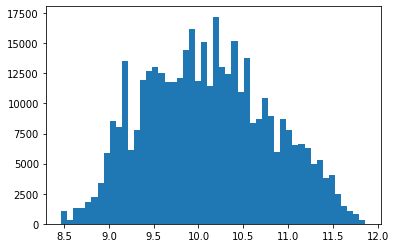

In [7]:
plt.hist(df.SalePrice.values, bins=50)

There is our base distribution. Let's try to get something similare on a test and validation set !

In [8]:
X, y = df.drop('SalePrice', axis=1), df.SalePrice.values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
X_train.shape, type(X_train), y_train.shape, type(y_train)

((320900, 36), pandas.core.frame.DataFrame, (320900,), numpy.ndarray)

In [11]:
y_train = y_train.reshape(-1, 1)

In [12]:
y_test = y_test.reshape(-1, 1)

In [13]:
minimal_df_size = int(len(X_train)/100); minimal_df_size

3209

In [14]:
X_train_sample = resample(X_train, replace=True, n_samples=minimal_df_size, random_state=0)

In [15]:
y_train_sample = resample(y_train, replace=True, n_samples=minimal_df_size, random_state=0)

In [16]:
X_test_sample = resample(X_test, replace=True, n_samples=minimal_df_size, random_state=1)

In [17]:
y_test_sample = resample(y_test, replace=True, n_samples=minimal_df_size, random_state=1)

In [18]:
(X_train_sample.shape, y_train_sample.shape)

((3209, 36), (3209, 1))

In [19]:
(y_train_sample.min(), y_train_sample.max(), y_train_sample.mean(), y_train_sample.std())

(8.517193191416238, 11.794337924408413, 10.118865252582957, 0.697376749520267)

(array([  9.,   8.,  11.,   1.,  13.,  21.,  20.,  56., 117.,  65.,  81.,
         30.,  88., 100.,  60.,  96.,  89., 102.,  98., 129.,  84., 115.,
         94., 117.,  86., 126., 122., 104.,  76.,  84., 119.,  76.,  72.,
         74.,  83.,  63.,  45.,  82.,  46.,  52.,  62.,  47.,  26.,  47.,
         36.,  19.,  33.,  14.,   5.,   6.]),
 array([ 8.51719319,  8.58273609,  8.64827898,  8.71382188,  8.77936477,
         8.84490766,  8.91045056,  8.97599345,  9.04153635,  9.10707924,
         9.17262214,  9.23816503,  9.30370793,  9.36925082,  9.43479372,
         9.50033661,  9.56587951,  9.6314224 ,  9.6969653 ,  9.76250819,
         9.82805108,  9.89359398,  9.95913687, 10.02467977, 10.09022266,
        10.15576556, 10.22130845, 10.28685135, 10.35239424, 10.41793714,
        10.48348003, 10.54902293, 10.61456582, 10.68010872, 10.74565161,
        10.8111945 , 10.8767374 , 10.94228029, 11.00782319, 11.07336608,
        11.13890898, 11.20445187, 11.26999477, 11.33553766, 11.40108056,
 

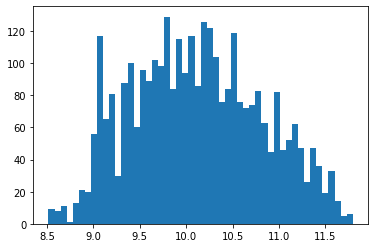

In [20]:
plt.hist(y_train_sample, bins=50)

In [21]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train_sample, y_train_sample)
m.score(X_train_sample, y_train_sample)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 3.07 s, sys: 39.9 ms, total: 3.11 s
Wall time: 481 ms


0.9642848804380992

In [22]:
preds = m.predict(X_test)

In [23]:
regression_results(y_test, preds)

explained_variance:  0.7397
mean_squared_log_error:  0.001
r2:  0.7392
MAE:  0.2662
MSE:  0.1257
RMSE:  0.3545


Okay so here are our numbers from a sample data how isn't even randomised.

The R2 and the explained variance are similare, the RMSE is pretty high but we'll try another approach to try to generalize better !

## What if we randomized our sample ?

Let's try to use a random sample this time.

In [24]:
X, y = df.drop('SalePrice', axis=1), df.SalePrice.values

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
X_train.shape, type(X_train), y_train.shape, type(y_train)

((320900, 36), pandas.core.frame.DataFrame, (320900,), numpy.ndarray)

In [27]:
y_train = y_train.reshape(-1, 1)

In [28]:
y_test = y_test.reshape(-1, 1)

In [29]:
minimal_df_size = int(len(X_train)/100); minimal_df_size

3209

In [30]:
X_train_sample = resample(X_train, replace=True, n_samples=minimal_df_size, random_state=1)

In [31]:
y_train_sample = resample(y_train, replace=True, n_samples=minimal_df_size, random_state=1)

In [32]:
X_test_sample = resample(X_test, replace=True, n_samples=minimal_df_size, random_state=1)

In [33]:
y_test_sample = resample(y_test, replace=True, n_samples=minimal_df_size, random_state=1)

In [34]:
(X_train_sample.shape, y_train_sample.shape)

((3209, 36), (3209, 1))

In [35]:
(y_train_sample.min(), y_train_sample.max(), y_train_sample.mean(), y_train_sample.std())

(8.465899897028686, 11.831379196088763, 10.105780803662698, 0.6901670635327153)

(array([  6.,   2.,   8.,  11.,  19.,  18.,  23.,  44.,  64.,  71.,  51.,
        112.,  68.,  89., 104.,  39.,  86.,  99., 136., 108., 129.,  79.,
        124.,  92., 150., 108., 132.,  89.,  82.,  93., 112.,  96.,  69.,
         72.,  76.,  36.,  68.,  69.,  54.,  62.,  56.,  49.,  36.,  39.,
         27.,  22.,  12.,  13.,   3.,   2.]),
 array([ 8.4658999 ,  8.53320948,  8.60051907,  8.66782865,  8.73513824,
         8.80244783,  8.86975741,  8.937067  ,  9.00437658,  9.07168617,
         9.13899576,  9.20630534,  9.27361493,  9.34092451,  9.4082341 ,
         9.47554369,  9.54285327,  9.61016286,  9.67747244,  9.74478203,
         9.81209162,  9.8794012 ,  9.94671079, 10.01402037, 10.08132996,
        10.14863955, 10.21594913, 10.28325872, 10.3505683 , 10.41787789,
        10.48518748, 10.55249706, 10.61980665, 10.68711623, 10.75442582,
        10.82173541, 10.88904499, 10.95635458, 11.02366416, 11.09097375,
        11.15828334, 11.22559292, 11.29290251, 11.36021209, 11.42752168,
 

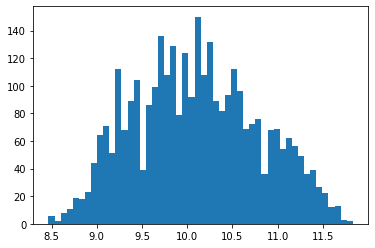

In [36]:
plt.hist(y_train_sample, bins=50)

In [37]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train_sample, y_train_sample)
m.score(X_train_sample, y_train_sample)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 3.07 s, sys: 28 ms, total: 3.1 s
Wall time: 451 ms


0.9648591971148792

In [38]:
preds = m.predict(X_test)

In [39]:
regression_results(y_test, preds)

explained_variance:  0.7401
mean_squared_log_error:  0.001
r2:  0.74
MAE:  0.2673
MSE:  0.1253
RMSE:  0.3539


The numbers on a randomized sample looks similar to an origianl one. What if we also randomize our train and validation set ?

## What if we randomized the train/validation set AND the sample ?

Let's try to use a random sample this time.

In [40]:
X, y = df.drop('SalePrice', axis=1), df.SalePrice.values

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [42]:
X_train.shape, type(X_train), y_train.shape, type(y_train)

((320900, 36), pandas.core.frame.DataFrame, (320900,), numpy.ndarray)

In [43]:
y_train = y_train.reshape(-1, 1)

In [44]:
y_test = y_test.reshape(-1, 1)

In [45]:
minimal_df_size = int(len(X_train)/100); minimal_df_size

3209

In [46]:
X_train_sample = resample(X_train, replace=True, n_samples=minimal_df_size, random_state=1)

In [47]:
y_train_sample = resample(y_train, replace=True, n_samples=minimal_df_size, random_state=1)

In [48]:
X_test_sample = resample(X_test, replace=True, n_samples=minimal_df_size, random_state=1)

In [49]:
y_test_sample = resample(y_test, replace=True, n_samples=minimal_df_size, random_state=1)

In [50]:
(X_train_sample.shape, y_train_sample.shape)

((3209, 36), (3209, 1))

In [51]:
(y_train_sample.min(), y_train_sample.max(), y_train_sample.mean(), y_train_sample.std())

(8.465899897028686, 11.842229212112828, 10.126867491313003, 0.6832482617646924)

(array([ 11.,   2.,  10.,  10.,  12.,  16.,  22.,  45.,  49.,  69.,  43.,
        108.,  68.,  90.,  88.,  45.,  91., 139., 104.,  93., 108.,  82.,
        111., 142.,  87., 118., 136., 101., 113., 136.,  92.,  94.,  73.,
         87.,  68.,  59.,  71.,  47.,  71.,  60.,  48.,  41.,  35.,  38.,
         20.,  33.,   6.,   6.,   7.,   4.]),
 array([ 8.4658999 ,  8.53342648,  8.60095307,  8.66847966,  8.73600624,
         8.80353283,  8.87105941,  8.938586  ,  9.00611259,  9.07363917,
         9.14116576,  9.20869235,  9.27621893,  9.34374552,  9.41127211,
         9.47879869,  9.54632528,  9.61385186,  9.68137845,  9.74890504,
         9.81643162,  9.88395821,  9.9514848 , 10.01901138, 10.08653797,
        10.15406455, 10.22159114, 10.28911773, 10.35664431, 10.4241709 ,
        10.49169749, 10.55922407, 10.62675066, 10.69427724, 10.76180383,
        10.82933042, 10.896857  , 10.96438359, 11.03191018, 11.09943676,
        11.16696335, 11.23448994, 11.30201652, 11.36954311, 11.43706969,
 

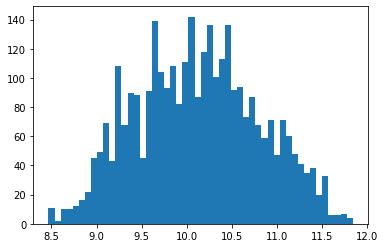

In [52]:
plt.hist(y_train_sample, bins=50)

In [53]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train_sample, y_train_sample)
m.score(X_train_sample, y_train_sample)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 3.07 s, sys: 24.5 ms, total: 3.1 s
Wall time: 456 ms


0.9624549670900356

In [54]:
preds = m.predict(X_test)

In [55]:
regression_results(y_test, preds)

explained_variance:  0.7358
mean_squared_log_error:  0.001
r2:  0.7354
MAE:  0.2702
MSE:  0.1278
RMSE:  0.3575


## Let's try enhance our fitting results by using logarithms !

With our SalePrice as log it could probably be enhance :D

In [56]:
X, y = df.drop('SalePrice', axis=1), np.log(df.SalePrice.values)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [58]:
X_train.shape, type(X_train), y_train.shape, type(y_train)

((320900, 36), pandas.core.frame.DataFrame, (320900,), numpy.ndarray)

In [59]:
y_train = y_train.reshape(-1, 1)

In [60]:
y_test = y_test.reshape(-1, 1)

In [61]:
minimal_df_size = int(len(X_train)/100); minimal_df_size

3209

In [62]:
X_train_sample = resample(X_train, replace=True, n_samples=minimal_df_size, random_state=1)

In [63]:
y_train_sample = resample(y_train, replace=True, n_samples=minimal_df_size, random_state=1)

In [64]:
X_test_sample = resample(X_test, replace=True, n_samples=minimal_df_size, random_state=1)

In [65]:
y_test_sample = resample(y_test, replace=True, n_samples=minimal_df_size, random_state=1)

In [66]:
(X_train_sample.shape, y_train_sample.shape)

((3209, 36), (3209, 1))

In [67]:
(y_train_sample.min(), y_train_sample.max(), y_train_sample.mean(), y_train_sample.std())

(2.1360463179122053,
 2.471671889783842,
 2.3129118957088366,
 0.06758154918988253)

(array([ 11.,   2.,   8.,   2.,  11.,  11.,  16.,  22.,  43.,  48.,  66.,
         42.,  74.,  50.,  98.,  56.,  84.,  97.,  95.,  82., 104.,  93.,
        108.,  82., 111.,  98., 131., 118., 136., 101., 113., 136.,  92.,
         99.,  68., 105.,  70.,  68.,  54.,  70.,  73.,  57.,  55.,  39.,
         34.,  35.,  21.,   7.,   9.,   4.]),
 array([2.13604632, 2.14275883, 2.14947134, 2.15618385, 2.16289636,
        2.16960888, 2.17632139, 2.1830339 , 2.18974641, 2.19645892,
        2.20317143, 2.20988394, 2.21659646, 2.22330897, 2.23002148,
        2.23673399, 2.2434465 , 2.25015901, 2.25687152, 2.26358404,
        2.27029655, 2.27700906, 2.28372157, 2.29043408, 2.29714659,
        2.3038591 , 2.31057162, 2.31728413, 2.32399664, 2.33070915,
        2.33742166, 2.34413417, 2.35084668, 2.3575592 , 2.36427171,
        2.37098422, 2.37769673, 2.38440924, 2.39112175, 2.39783426,
        2.40454678, 2.41125929, 2.4179718 , 2.42468431, 2.43139682,
        2.43810933, 2.44482184, 2.45153436, 2.

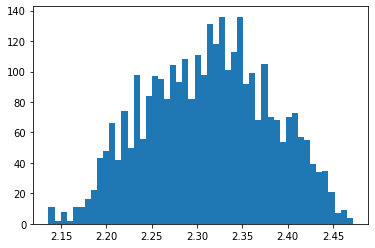

In [68]:
plt.hist(y_train_sample, bins=50)

In [69]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train_sample, y_train_sample)
m.score(X_train_sample, y_train_sample)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 3.09 s, sys: 13.2 ms, total: 3.1 s
Wall time: 452 ms


0.9620875099517638

In [70]:
preds = m.predict(X_test)

In [71]:
regression_results(y_test, preds)

explained_variance:  0.7321
mean_squared_log_error:  0.0001
r2:  0.7317
MAE:  0.0269
MSE:  0.0013
RMSE:  0.0356


Instantly the RMSE is going down, it's incredible how this metric was sensitive to this !

---

### Feature selection

#### Basic first try
Let's try to select the most usefull features with an automated approach

In [72]:
# from sklearn.feature_selection import SequentialFeatureSelector

# #Selecting the Best important features according to RandomForestRegressor
# sfs_selector = SequentialFeatureSelector(estimator=RandomForestRegressor(), 
#                                         n_features_to_select=10,
#                                         cv=4,
#                                         direction ='backward')

# sfs_selector.fit(X_train_boot, y_train_boot)
# X.columns[sfs_selector.get_support()]

We try boostraping with the previous method of feature selection but it doesen't work.

Even with a very tiny part of our dataset (0.8% random parts from the original set) the computation take too much time (more than 10mins on an 8 core CPU).

#### Fastai approach of feature Importance

In [73]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_})

def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [74]:
%time fi = rf_feat_importance(m, X_train_sample); fi

CPU times: user 15.4 ms, sys: 3.5 ms, total: 18.9 ms
Wall time: 12.4 ms


,cols,imp
0,SalesID,0.041368
1,MachineID,0.032915
2,ModelID,0.124709
3,datasource,0.002058
4,auctioneerID,0.009494
5,YearMade,0.138240
6,MachineHoursCurrentMeter,0.022455
7,UsageBand,0.004137
8,fiModelDesc,0.043481
9,fiBaseModel,0.031190


This approach is manuel but yet efficient and powerfull !

Let's select the most interesting features :

<AxesSubplot:ylabel='cols'>

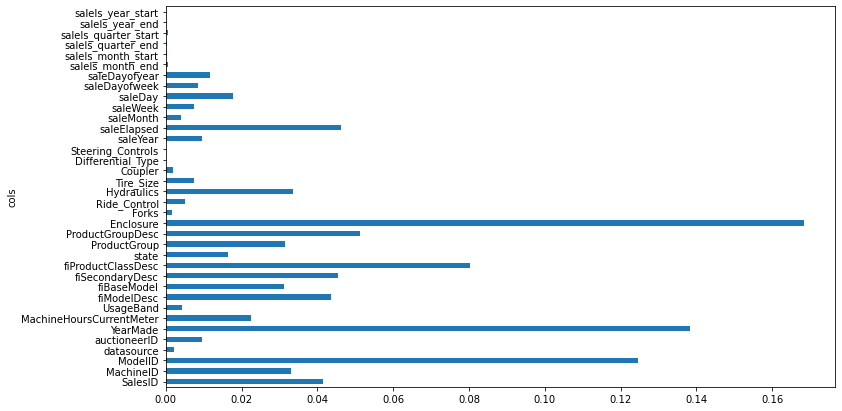

In [75]:
plot_fi(fi)

In [76]:
fi.shape

(36, 2)

<AxesSubplot:ylabel='cols'>

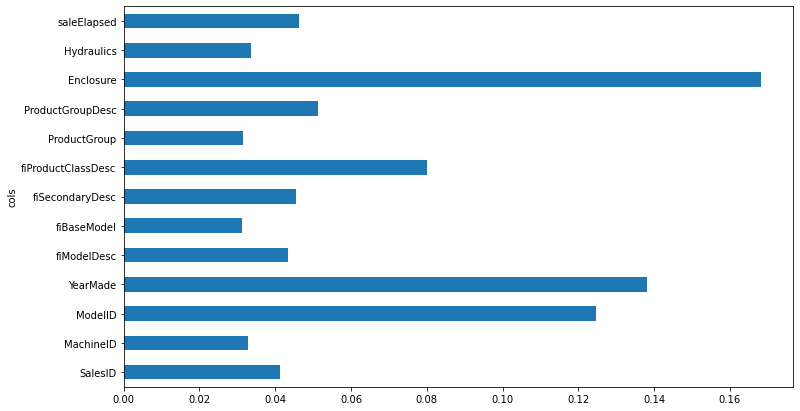

In [77]:
to_keep = fi[fi.imp > 0.025]
plot_fi(to_keep)

In [78]:
to_keep.shape

(13, 2)

---

## Optimizing training time and results with features importance

In [79]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train_sample[to_keep.cols], y_train_sample[:])
m.score(X_test_sample[to_keep.cols], y_test_sample[:])

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 1.55 s, sys: 32.5 ms, total: 1.59 s
Wall time: 267 ms


0.7535512173581491

In [80]:
preds = m.predict(X_test[to_keep.cols])

In [81]:
regression_results(y_test, preds)

explained_variance:  0.7533
mean_squared_log_error:  0.0001
r2:  0.7529
MAE:  0.0256
MSE:  0.0012
RMSE:  0.0342


This is becomming better and better, we just won 0.02 on our variance and R2 !

### Let's try to use even less feature

<AxesSubplot:ylabel='cols'>

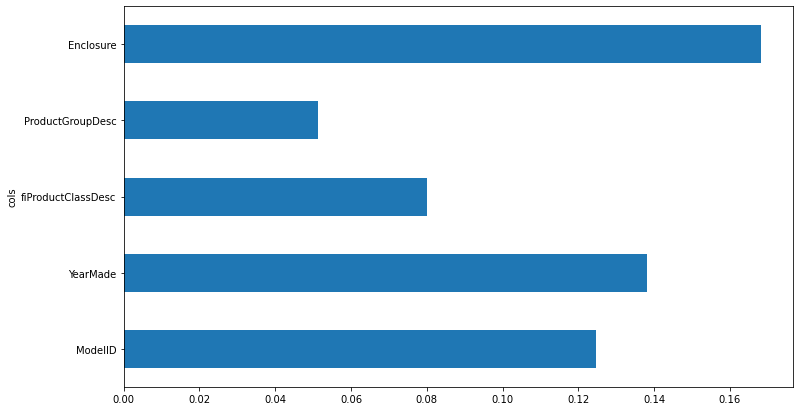

In [82]:
to_keep = fi[fi.imp > 0.05]
plot_fi(to_keep)

In [83]:
to_keep.shape

(5, 2)

In [84]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train_sample[to_keep.cols], y_train_sample[:])
m.score(X_test_sample[to_keep.cols], y_test_sample[:])

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 2.61 s, sys: 220 ms, total: 2.83 s
Wall time: 774 ms


0.6848194288329388

In [85]:
preds = m.predict(X_test[to_keep.cols])

In [86]:
regression_results(y_test, preds)

explained_variance:  0.6831
mean_squared_log_error:  0.0001
r2:  0.6827
MAE:  0.0296
MSE:  0.0015
RMSE:  0.0387


Our results are less good, maybe it was too much, let's try with a more reasonable number of features.

### Let's try to use even less feature

<AxesSubplot:ylabel='cols'>

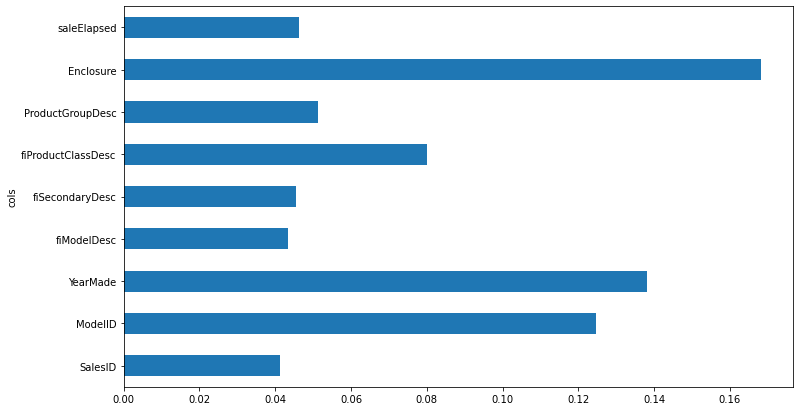

In [87]:
to_keep = fi[fi.imp > 0.04]
plot_fi(to_keep)

In [88]:
to_keep.shape

(9, 2)

In [89]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train_sample[to_keep.cols], y_train_sample[:])
m.score(X_test_sample[to_keep.cols], y_test_sample[:])

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 4.07 s, sys: 107 ms, total: 4.18 s
Wall time: 754 ms


0.7646611684508946

In [90]:
preds = m.predict(X_test[to_keep.cols])

In [91]:
regression_results(y_test, preds)

explained_variance:  0.7657
mean_squared_log_error:  0.0001
r2:  0.7652
MAE:  0.0249
MSE:  0.0011
RMSE:  0.0333


We're back into the number race, our numbers are continue to be better !